In [30]:
import numpy as np
import gmsh

In [31]:
densidad = 7850 #kg/m3
A = 10E-4 #m2
L_total = 1 #m
I = 10E-8 #m4
E = 210E9 #Pa
numero_elementos = 2
numero_nodos = numero_elementos+1

In [32]:
#armado de las matrices de nodos y conectividad
matriz_nodos = np.linspace(0  ,  L_total  ,  numero_elementos+1).reshape(-1  ,  1)
matriz_nodos = np.hstack([matriz_nodos   ,   np.zeros_like(matriz_nodos)])
matriz_conectividad = np.zeros((numero_elementos  ,  2))
for i in range(numero_elementos):
    matriz_conectividad[i  ,  0] = i
    matriz_conectividad[i  ,  1] = i+1
matriz_global_rigidez = np.zeros((2*numero_nodos  ,  2*numero_nodos))
matriz_global_concentrada = np.zeros((2*numero_nodos  ,  2*numero_nodos))
matriz_global_consistente = np.zeros((2*numero_nodos  ,  2*numero_nodos))
L = L_total/numero_elementos #Largo del elemento
#Definicion de los vectores r y s. Esta definido ad hoc en este caso, no esta automatizado
s = [0  ,  1]
r = (np.linspace(2  ,  2*numero_nodos-1  ,  2*numero_nodos-2)).astype(int)

In [33]:
#Creacion de las matrices globales de rigidez  ,   concentrada y consistente
for i in range (len(matriz_conectividad)):
    (a)  ,  (b) = matriz_conectividad[i] 
    a = int(a)
    b = int(b)

    coef_k = E*I/L**3
    k = coef_k*np.array([[12  ,  6*L  ,  -12  ,  6*L]  ,  [6*L  ,  4*L**2  ,  -6*L  ,  2*L**2]  ,  [-12  ,  -6*L  ,  12  ,  -6*L] , [6*L , 2*L**2 , -6*L , 4*L**2]])
    matriz_global_rigidez[2*a:2*(a+1) ,  2*a:2*(a+1)] += k [0:2 , 0:2]
    matriz_global_rigidez[2*(a):2*(a+1) ,  2*(b):2*(b+1)] += k [0:2 , 2:4]
    matriz_global_rigidez[2*b:2*(b+1) ,  2*b:2*(b+1)] += k [2:4 , 2:4]
    matriz_global_rigidez[2*b:2*(b+1) ,  2*a:2*(a+1)] += k [2:4 , 0:2]

    matriz_concentrada = densidad*A*(L/24)*np.array([[12 , 0 , 0 , 0] , [0 , L**2 , 0 , 0] , [0 , 0 , 12 , 0] , [0 , 0 , 0 , L**2]])
    matriz_global_concentrada[2*a:2*(a+1) ,  2*a:2*(a+1)] += matriz_concentrada [0:2 , 0:2]
    matriz_global_concentrada[2*(a):2*(a+1) ,  2*(b):2*(b+1)] += matriz_concentrada [0:2 , 2:4]
    matriz_global_concentrada[2*b:2*(b+1) ,  2*b:2*(b+1)] += matriz_concentrada [2:4 , 2:4]
    matriz_global_concentrada[2*b:2*(b+1) ,  2*a:2*(a+1)] += matriz_concentrada [2:4 , 0:2]

    matriz_consistente = densidad*A*(L/420)*np.array([[156 , 22*L , 54 , -13*L] , [22*L , 4*L**2 , 13*L , -3*L**2] , [54 , 13*L , 156 , -22*L] , [-13*L , -3*L**2 , -22*L , 4*L**2]])
    matriz_global_consistente[2*a:2*(a+1) ,  2*a:2*(a+1)] += matriz_consistente [0:2 , 0:2]
    matriz_global_consistente[2*(a):2*(a+1) ,  2*(b):2*(b+1)] += matriz_consistente [0:2 , 2:4]
    matriz_global_consistente[2*b:2*(b+1) ,  2*b:2*(b+1)] += matriz_consistente [2:4 , 2:4]
    matriz_global_consistente[2*b:2*(b+1) ,  2*a:2*(a+1)] += matriz_consistente [2:4 , 0:2]

In [34]:
#Calculo de autovalores (frecuencias) y autovectores (desplazamientos y angulos de rotacion). Se calcula para los nodos que no estén restringidos
from scipy.linalg import eigh 
w ,  vl_r = eigh(matriz_global_rigidez[np.ix_(r , r)] ,  matriz_global_concentrada[np.ix_(r , r)])
w_consistente ,  vl_r_consistente = eigh(matriz_global_rigidez[np.ix_(r , r)] ,  matriz_global_consistente[np.ix_(r , r)])

In [35]:
#Se le agrega fila de 0s a los autovectores de los nodos que estén restringidos en su movimiento o rotacion
for i in range (len(s)):
    vl_r = np.insert(vl_r , s[i] , 0 , axis=0)
    vl_r_consistente = np.insert(vl_r_consistente , s[i] , 0 , axis=0)
vl = vl_r
vl_consistente = vl_r_consistente

In [36]:
#Pasaje de w a f
frecuencia = np.sqrt(w)/(2*np.pi)
frecuencia_consistente = np.sqrt(w_consistente)/(2*np.pi)

In [37]:
#Normalizado de los autovectores. Los modos normales de desplazamiento se dividen por el último modo normal (el mas grande) ,  de manera que todos los modos normales quedan comprendidos en valores entre 0 y 1
vl_normalizado = vl/vl[2*numero_nodos-2 , :]
vl_normalizado_consistente = vl_consistente/vl_consistente[2*numero_nodos-2 , :]

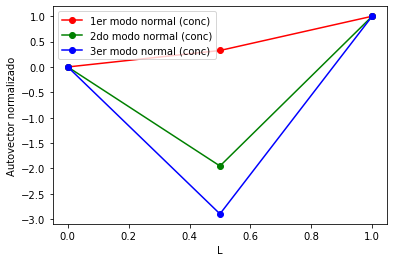

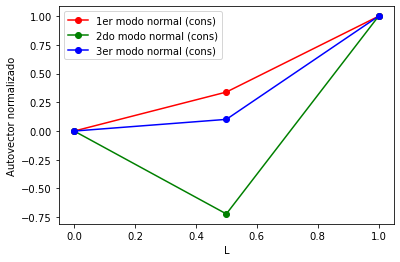

In [38]:
import matplotlib.pyplot as plt 
mn1 = np.zeros((numero_nodos , 1))
mn2 = np.zeros((numero_nodos , 1))
mn3 = np.zeros((numero_nodos , 1))
mn1_cons = np.zeros((numero_nodos , 1))
mn2_cons = np.zeros((numero_nodos , 1))
mn3_cons = np.zeros((numero_nodos , 1))

for i in range (numero_nodos):
    
    mn1[i] = vl_normalizado[2*i , 0]
    mn2[i] = vl_normalizado[2*i , 1]
    mn3[i] = vl_normalizado[2*i , 2]
    
    mn1_cons[i] = vl_normalizado_consistente[2*i , 0]
    mn2_cons[i] = vl_normalizado_consistente[2*i , 1]
    mn3_cons[i] = vl_normalizado_consistente[2*i , 2]

#grafico de los primeros 3 modos normales para el calculo con matrices concentradas
plt.plot(matriz_nodos[: , 0] , mn1 , 'r' , marker = 'o' ,  label = '1er modo normal (conc)')
plt.plot(matriz_nodos[: , 0] , mn2 , 'g' , marker = 'o' ,  label = '2do modo normal (conc)')
plt.plot(matriz_nodos[: , 0] , mn3 , 'b' , marker = 'o' ,  label = '3er modo normal (conc)')
plt.legend(loc = 'best')
plt.ylabel('Autovector normalizado')
plt.xlabel('L')
plt.show()

#grafico de los primeros 3 modos normales calculados con matrices consistentes
plt.plot(matriz_nodos[: , 0] , mn1_cons , 'r' , marker = 'o' ,  label = '1er modo normal (cons)')
plt.plot(matriz_nodos[: , 0] , mn2_cons , 'g' , marker = 'o' ,  label = '2do modo normal (cons)')
plt.plot(matriz_nodos[: , 0] , mn3_cons , 'b' , marker = 'o' ,  label = '3er modo normal (cons)')
plt.legend(loc = 'best')
plt.ylabel('Autovector normalizado')
plt.xlabel('L')
plt.show()

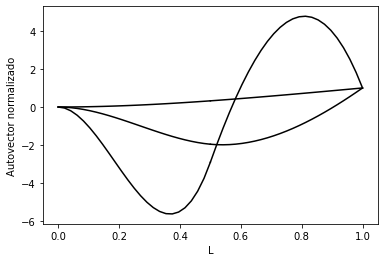

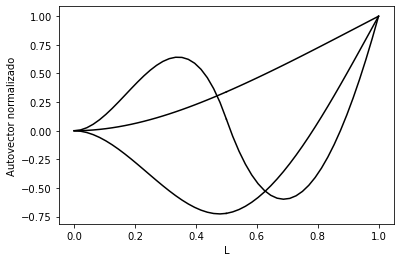

In [39]:
#Grafico de los autovectores normalizados mediante las funciones de interpolacion
v = lambda a1 , a2 , a3 , a4 , x: a1*x**3 + a2*x**2 + a3*x + a4
for j in range (3): #elijo 3 en el rango porque estoy graficando los primeros 3 modos normales
    for i in range ((numero_nodos-1)):
        a1 = (2/L**3)*(vl_normalizado[2*i , j]-vl_normalizado[2*(i+1) , j])+(1/L**2)*(vl_normalizado[2*i+1 , j]+vl_normalizado[2*(i+1)+1 , j])
        a2 = (-3/L**2)*(vl_normalizado[2*i , j]-vl_normalizado[2*(i+1) , j])-(1/L)*(2*vl_normalizado[2*i+1 , j]+vl_normalizado[2*(i+1)+1 , j])
        a3 = vl_normalizado[2*i+1 , j]
        a4 = vl_normalizado[2*i , j]
        plt.plot(np.linspace(i*L ,  (i+1)*L ,  25) ,  v(a1 ,  a2 ,  a3 ,  a4 ,  np.linspace(0 ,  L ,  25)) ,  'k')
plt.ylabel('Autovector normalizado')
plt.xlabel('L')
plt.show()
for j in range(3):  #elijo 3 en el rango porque estoy graficando los primeros 3 modos normales
    for i in range((numero_nodos-1)):
        a1 = (2/L**3)*(vl_normalizado_consistente[2*i , j]-vl_normalizado_consistente[2*(i+1) , j])+(1/L**2)*(vl_normalizado_consistente[2*i+1 , j]+vl_normalizado_consistente[2*(i+1)+1 , j])
        a2 = (-3/L**2)*(vl_normalizado_consistente[2*i , j]-vl_normalizado_consistente[2*(i+1) , j])-(1/L)*(2*vl_normalizado_consistente[2*i+1 , j]+vl_normalizado_consistente[2*(i+1)+1 , j])
        a3 = vl_normalizado_consistente[2*i+1 , j]
        a4 = vl_normalizado_consistente[2*i , j]
        plt.plot(np.linspace(i*L ,  (i+1)*L ,  25) ,  v(a1 ,  a2 ,  a3 ,  a4 ,  np.linspace(0 ,  L ,  25)) ,  'k')
plt.ylabel('Autovector normalizado')
plt.xlabel('L')
plt.show()



In [46]:
#Convergencia de la frecuencia a medida que se aumenta el número de nodos
densidad = 7850 #
A = 10E-4
L_total = 1
I = 10E-8
E = 210E9
frecuencia = []
frecuencia_consistente = []
convergencia = [2 , 20] #rango de cantidad de elementos que se analizarán. Para los primeros 3 modos normales se puede usar un rango [2,20]; para el 10mo modo normal, se puede dar un valor de [5, 50] para observar convergencia
for j in range(convergencia[0] , convergencia[1]):
    numero_elementos = j
    numero_nodos = numero_elementos+1
    matriz_nodos = np.linspace(0 , L_total , numero_elementos+1).reshape(-1 , 1)
    matriz_nodos = np.hstack([matriz_nodos  ,  np.zeros_like(matriz_nodos)])
    matriz_conectividad = np.zeros((numero_elementos , 2))
    for i in range(numero_elementos):
        matriz_conectividad[i , 0] = i
        matriz_conectividad[i , 1] = i+1
    matriz_global_rigidez = np.zeros((2*numero_nodos , 2*numero_nodos))
    matriz_global_concentrada = np.zeros((2*numero_nodos , 2*numero_nodos))
    matriz_global_consistente = np.zeros((2*numero_nodos , 2*numero_nodos))
    L = L_total/numero_elementos
    s = [0 , 1]
    r = (np.linspace(2 , 2*numero_nodos-1 , 2*numero_nodos-2)).astype(int)
    for i in range (len(matriz_conectividad)):
        (a) , (b) = matriz_conectividad[i] 
        a = int(a)
        b = int(b)

        coef_k = E*I/L**3
        k = coef_k*np.array([[12 , 6*L , -12 , 6*L] , [6*L , 4*L**2 , -6*L , 2*L**2] , [-12 , -6*L , 12 , -6*L] , [6*L , 2*L**2 , -6*L , 4*L**2]])
        matriz_global_rigidez[2*a:2*(a+1) ,  2*a:2*(a+1)] += k [0:2 , 0:2]
        matriz_global_rigidez[2*(a):2*(a+1) ,  2*(b):2*(b+1)] += k [0:2 , 2:4]
        matriz_global_rigidez[2*b:2*(b+1) ,  2*b:2*(b+1)] += k [2:4 , 2:4]
        matriz_global_rigidez[2*b:2*(b+1) ,  2*a:2*(a+1)] += k [2:4 , 0:2]

        matriz_concentrada = densidad*A*(L/24)*np.array([[12 , 0 , 0 , 0] , [0 , L**2 , 0 , 0] , [0 , 0 , 12 , 0] , [0 , 0 , 0 , L**2]])
        matriz_global_concentrada[2*a:2*(a+1) ,  2*a:2*(a+1)] += matriz_concentrada [0:2 , 0:2]
        matriz_global_concentrada[2*(a):2*(a+1) ,  2*(b):2*(b+1)] += matriz_concentrada [0:2 , 2:4]
        matriz_global_concentrada[2*b:2*(b+1) ,  2*b:2*(b+1)] += matriz_concentrada [2:4 , 2:4]
        matriz_global_concentrada[2*b:2*(b+1) ,  2*a:2*(a+1)] += matriz_concentrada [2:4 , 0:2]

        matriz_consistente = densidad*A*(L/420)*np.array([[156 , 22*L , 54 , -13*L] , [22*L , 4*L**2 , 13*L , -3*L**2] , [54 , 13*L , 156 , -22*L] , [-13*L , -3*L**2 , -22*L , 4*L**2]])
        matriz_global_consistente[2*a:2*(a+1) ,  2*a:2*(a+1)] += matriz_consistente [0:2 , 0:2]
        matriz_global_consistente[2*(a):2*(a+1) ,  2*(b):2*(b+1)] += matriz_consistente [0:2 , 2:4]
        matriz_global_consistente[2*b:2*(b+1) ,  2*b:2*(b+1)] += matriz_consistente [2:4 , 2:4]
        matriz_global_consistente[2*b:2*(b+1) ,  2*a:2*(a+1)] += matriz_consistente [2:4 , 0:2]
    from scipy.linalg import eigh 
    w ,  vl_r = eigh(matriz_global_rigidez[np.ix_(r , r)] ,  matriz_global_concentrada[np.ix_(r , r)])
    w_consistente ,  vl_r_consistente = eigh(matriz_global_rigidez[np.ix_(r , r)] ,  matriz_global_consistente[np.ix_(r , r)])
    frecuencia.append(np.sqrt(w)/(2*np.pi))
    frecuencia_consistente.append(np.sqrt(w_consistente)/(2*np.pi))

In [47]:
mn1 = np.zeros((convergencia[1]-convergencia[0] , 1))
mn2 = np.zeros((convergencia[1]-convergencia[0] , 1))
mn3 = np.zeros((convergencia[1]-convergencia[0] , 1))
mn1_cons = np.zeros((convergencia[1]-convergencia[0] , 1))
mn2_cons = np.zeros((convergencia[1]-convergencia[0] , 1))
mn3_cons = np.zeros((convergencia[1]-convergencia[0] , 1))
mn10 = np.zeros((convergencia[1]-convergencia[0] , 1))
mn10_cons = np.zeros((convergencia[1]-convergencia[0] , 1))

for i in range (convergencia[1]-convergencia[0]):
    #Asignacion de las frecuencias calculadas con matrices concentradas
    mn1[i] = frecuencia[i][0]
    mn2[i] = frecuencia[i][1]
    mn3[i] = frecuencia[i][2]
    mn10[i] = frecuencia[i][9] #Requiere poner un numero mayor o igual a 5 en convergencia[0]
    #Asignacion de las frecuencias calculadas con matrices consistentes
    mn1_cons[i] = frecuencia_consistente[i][0]
    mn2_cons[i] = frecuencia_consistente[i][1]
    mn3_cons[i] = frecuencia_consistente[i][2]
#    mn10_cons[i] = frecuencia_consistente[i][9]
elementos = np.linspace(convergencia[0] , convergencia[1]-1 , convergencia[1]-convergencia[0])

(8, 1)


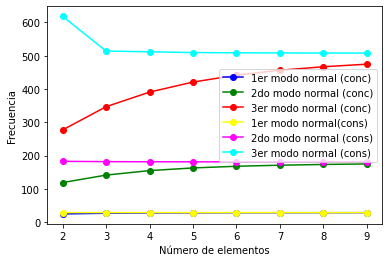

In [42]:
#Gráfico de los resultados
print(mn1_cons.shape)
plt.plot(elementos ,  mn1 , 'b' , marker = 'o' ,  label = "1er modo normal (conc)")
plt.plot(elementos ,  mn2 , 'g' , marker = 'o' ,  label = "2do modo normal (conc)")
plt.plot(elementos ,  mn3 , 'r' , marker = 'o' ,  label = "3er modo normal (conc)")
plt.plot(elementos ,  mn1_cons , 'yellow' , marker = 'o' ,  label = "1er modo normal(cons)")
plt.plot(elementos ,  mn2_cons , 'magenta' , marker = 'o' ,  label = "2do modo normal (cons)")
plt.plot(elementos ,  mn3_cons , 'cyan' , marker = 'o' ,  label = "3er modo normal (cons)")
#plt.plot(elementos ,  mn10 , 'k' , marker = 'o' ,  label = "10mo modo normal (conc)")
#plt.plot(elementos ,  mn10_cons , 'grey' , marker = 'o' ,  label = "10mo modo normal (cons)")
plt.legend(loc  =  'best')
plt.ylabel('Frecuencia')
plt.xlabel('Número de elementos')
plt.show()